<a href="https://colab.research.google.com/github/antonioalmudevar/APL/blob/main/anomaly_fan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def conv2d_outputshape(input_shape, nfilters, kernel_size, stride, padding):
    if type(kernel_size)!=list: kernel_size = [kernel_size, kernel_size]
    if type(stride)!=list: stride = [stride, stride]
    if type(padding)!=list: padding = [padding, padding]

    output_shape = np.zeros((3),int)
    output_shape[0] = (int)(nfilters)
    output_shape[1] = (int)(np.floor((input_shape[1] - kernel_size[0] + 2*padding[0] ) / stride[0]) + 1)
    output_shape[2] = (int)(np.floor((input_shape[2] - kernel_size[1] + 2*padding[1] ) / stride[1]) + 1)

    return output_shape

def conv2dtranspose_outputshape(input_shape, nfilters, kernel_size, stride, padding, output_padding=0):
    if type(kernel_size)!=list: kernel_size = [kernel_size, kernel_size]
    if type(stride)!=list: stride = [stride, stride]
    if type(padding)!=list: padding = [padding, padding]
    if type(output_padding)!=list: output_padding = [output_padding, output_padding]

    output_shape = np.zeros((3),int)
    output_shape[0] = (int)(nfilters)
    output_shape[1] = (int)((input_shape[1]-1)*stride[0] + kernel_size[0] - 2*padding[0] + output_padding[0])
    output_shape[2] = (int)((input_shape[2]-1)*stride[1] + kernel_size[1] - 2*padding[1] + output_padding[1])

    return output_shape

In [1]:
from google.colab import drive
!pip install import_ipynb &> /dev/null
import import_ipynb
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/DCASE2020

Mounted at /content/drive
/content/drive/My Drive/DCASE2020


In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def audio2mel_db(samples, sample_rate, n_fft=2048, win_length=None, 
              hop_length=None, n_mels=128, plot=False):

    if win_length==None: win_length = n_fft
    if hop_length==None: hop_length = win_length//2

    sgram = librosa.stft(samples,n_fft,hop_length,win_length)
    sgram_mag, _ = librosa.magphase(sgram)
    mel_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate, 
                                                     n_mels=n_mels)
    mel_db_sgram = librosa.amplitude_to_db(mel_sgram, ref=np.min)

    if plot: 
        librosa.display.specshow(mel_db_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')

    return mel_db_sgram

In [4]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os

class fanDataset(Dataset):
    def __init__(self, id_fan=[0], L=5, train=True, normal=True):
        assert L%2, "L must be odd"

        data = []
        id_records_train = [911,915,932,914]
        id_records_test_normal = [99,99,99,99]
        id_records_test_anomaly = [406,358,347,360]
        for i in range(len(id_fan)):
            if train:
                for j in range(id_records_train[i]):
                    AUDIO_FILE = './train/normal_id_'+f'{id_fan[i]:02d}'+'_'+f'{j:08d}'+'.wav'
                    samples, sample_rate = librosa.load(AUDIO_FILE, sr=None) 
                    mel = audio2mel_db(samples,sample_rate,n_fft=1024,n_mels=64)
                    data.append( (mel-np.min(mel)) / (np.max(mel)-np.min(mel)) )
            else:
                if normal:
                    for j in range(id_records_test_normal[i]):
                        AUDIO_FILE = './test/normal_id_'+f'{id_fan[i]:02d}'+'_'+f'{j:08d}'+'.wav'
                        samples, sample_rate = librosa.load(AUDIO_FILE, sr=None) 
                        mel = audio2mel_db(samples,sample_rate,n_fft=1024,n_mels=64)
                        data.append( (mel-np.min(mel)) / (np.max(mel)-np.min(mel)) )
                else:
                    for j in range(id_records_test_anomaly[i]):
                        AUDIO_FILE = './test/anomaly_id_'+f'{id_fan[i]:02d}'+'_'+f'{j:08d}'+'.wav'
                        samples, sample_rate = librosa.load(AUDIO_FILE, sr=None) 
                        mel = audio2mel_db(samples,sample_rate,n_fft=1024,n_mels=64)
                        data.append( (mel-np.min(mel)) / (np.max(mel)-np.min(mel)) )                      

        data = np.asarray(data).swapaxes(1,2)

        self.data_in = np.zeros((data.shape[0],data.shape[1]-L+1,L-1,data.shape[2]),np.float32)
        for i in range (data.shape[1]-L+1):
            self.data_in[:,i,:,:] = np.concatenate((data[:,i:i+L//2,:],data[:,i+L-L//2:i+L,:]),1)
        self.data_in = self.data_in.reshape(-1,(L-1)*data.shape[2])
        
        self.data_out = (data[:,L//2:data.shape[1]-L//2,:]).reshape(-1,data.shape[2])

        self.data_in = torch.from_numpy(self.data_in)
        self.data_out = torch.from_numpy(self.data_out)

    def __len__(self):
        return len(self.data_in)

    def __getitem__(self, idx):
        return self.data_in[idx], self.data_out[idx]

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(256,64),
            nn.ReLU(True),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.BatchNorm1d(32),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.BatchNorm1d(16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16,32),
            nn.ReLU(True),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = autoencoder().cuda()
criterion = nn.MSELoss()

dataset = fanDataset(train=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
num_epochs = 50
batch_size = 64
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for data_in, data_out in dataloader:
        data_in, data_out = Variable(data_in).cuda(), Variable(data_out).cuda()
        # ===================forward=====================
        output = model(data_in)
        loss = criterion(output, data_out)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data))

epoch [1/50], loss:0.0029
epoch [2/50], loss:0.0030
epoch [3/50], loss:0.0030
epoch [4/50], loss:0.0030
epoch [5/50], loss:0.0029
epoch [6/50], loss:0.0034
epoch [7/50], loss:0.0030
epoch [8/50], loss:0.0031
epoch [9/50], loss:0.0032
epoch [10/50], loss:0.0031
epoch [11/50], loss:0.0031
epoch [12/50], loss:0.0032
epoch [13/50], loss:0.0037
epoch [14/50], loss:0.0028
epoch [15/50], loss:0.0030
epoch [16/50], loss:0.0033
epoch [17/50], loss:0.0031
epoch [18/50], loss:0.0033
epoch [19/50], loss:0.0035
epoch [20/50], loss:0.0035
epoch [21/50], loss:0.0030
epoch [22/50], loss:0.0035
epoch [23/50], loss:0.0030
epoch [24/50], loss:0.0029
epoch [25/50], loss:0.0030
epoch [26/50], loss:0.0030
epoch [27/50], loss:0.0031
epoch [28/50], loss:0.0031
epoch [29/50], loss:0.0033
epoch [30/50], loss:0.0030
epoch [31/50], loss:0.0033
epoch [32/50], loss:0.0041
epoch [33/50], loss:0.0036
epoch [34/50], loss:0.0031
epoch [35/50], loss:0.0033
epoch [36/50], loss:0.0032
epoch [37/50], loss:0.0031
epoch [38/

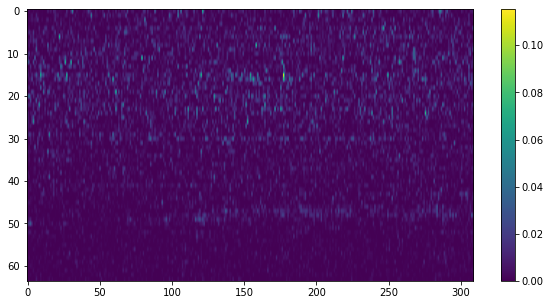

In [8]:
test = fanDataset(train=False, normal=True)
test_dataloader = DataLoader(test, batch_size=len(test), shuffle=False)
with torch.no_grad():
    for test_in, test_out in test_dataloader:
        test_in = Variable(test_in).cuda()
        test_pred = model(test_in)

test_out = test_out.reshape(99,-1,64).numpy().swapaxes(1,2)
test_pred = test_pred.reshape(99,-1,64).cpu().data.numpy().swapaxes(1,2)
error_normal = (test_out-test_pred)**2

plt.figure(figsize=(10,5))
plt.imshow(error_normal[10], aspect='auto')
plt.colorbar()
plt.show()

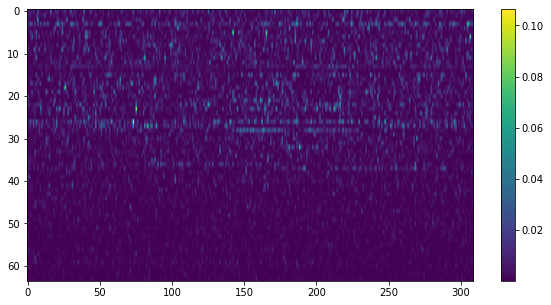

In [9]:
test = fanDataset(train=False, normal=False)
test_dataloader = DataLoader(test, batch_size=len(test), shuffle=False)
with torch.no_grad():
    for test_in, test_out in test_dataloader:
        test_in = Variable(test_in).cuda()
        test_pred = model(test_in)

test_out = test_out.reshape(406,-1,64).numpy().swapaxes(1,2)
test_pred = test_pred.reshape(406,-1,64).cpu().data.numpy().swapaxes(1,2)
error_anomaly = (test_out-test_pred)**2

plt.figure(figsize=(10,5))
plt.imshow(error_anomaly[100], aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
error_anomaly[0].shape

(64, 309)

In [ ]:
print('Error anomalía: '+str(np.sum(error_anomaly[0],axis=(0,1))))
print('Error normalidad: '+str(np.sum(error_normal[0],axis=(0,1))))

Error anomalía: 41.617294
Error normalidad: 46.79658
